In [26]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [27]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [28]:
NUM_CLASSES = 3

# 入力長

In [29]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [30]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [31]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [33]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [34]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                792       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                250       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1075 (4.20 KB)
Trainable params: 1075 (4.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [36]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [37]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


 1/20 [>.............................] - ETA: 28s - loss: 1.1176 - accuracy: 0.4219
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.hdf5
20/20 [==============================] - 2s 23ms/step - loss: 1.0993 - accuracy: 0.5397 - val_loss: 1.0669 - val_accuracy: 0.4945
Epoch 2/1000
11/20 [===============>..............] - ETA: 0s - loss: 1.0609 - accuracy: 0.5845

/home/chuptani/.conda/envs/compvision/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/point_history_classifier/point_history_classifier.hdf5
20/20 [==============================] - 0s 11ms/step - loss: 1.0524 - accuracy: 0.5906 - val_loss: 1.0203 - val_accuracy: 0.5995
Epoch 3/1000
12/20 [=================>............] - ETA: 0s - loss: 1.0126 - accuracy: 0.6309
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.hdf5
20/20 [==============================] - 0s 10ms/step - loss: 1.0042 - accuracy: 0.6390 - val_loss: 0.9690 - val_accuracy: 0.6300
Epoch 4/1000
11/20 [===============>..............] - ETA: 0s - loss: 0.9639 - accuracy: 0.6541
Epoch 4: saving model to model/point_history_classifier/point_history_classifier.hdf5
20/20 [==============================] - 0s 15ms/step - loss: 0.9518 - accuracy: 0.6654 - val_loss: 0.9128 - val_accuracy: 0.6484
Epoch 5/1000
18/20 [==========================>...] - ETA: 0s - loss: 0.9021 - accuracy: 0.6840
Epoch 5: saving model to model/point_history_classifier/point_h

In [38]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [39]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 90ms/step
[0.99159944 0.00615144 0.00224917]
0


# 混同行列

26/26 [==============================] - 0s 2ms/step


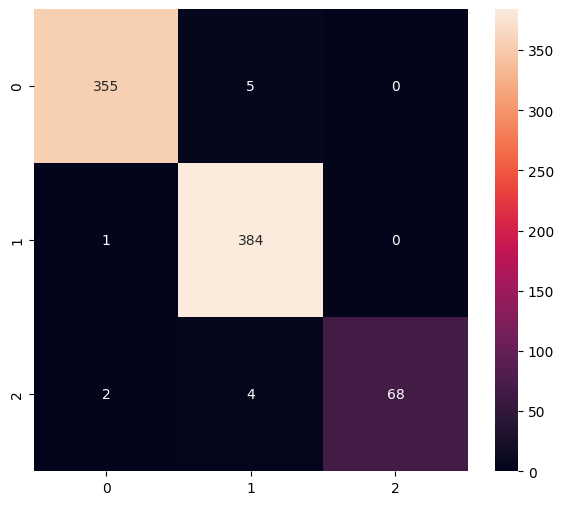

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       360
           1       0.98      1.00      0.99       385
           2       1.00      0.92      0.96        74

    accuracy                           0.99       819
   macro avg       0.99      0.97      0.98       819
weighted avg       0.99      0.99      0.99       819



In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [41]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

/home/chuptani/.conda/envs/compvision/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [43]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [44]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [51]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpg5f7zwjt/assets


INFO:tensorflow:Assets written to: /tmp/tmpg5f7zwjt/assets
2024-03-01 16:09:21.068513: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-01 16:09:21.068583: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-01 16:09:21.068830: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpg5f7zwjt
2024-03-01 16:09:21.069751: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-01 16:09:21.069774: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpg5f7zwjt
2024-03-01 16:09:21.073009: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-01 16:09:21.097107: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpg5f7zwjt
2024-03-01 16:09:21.108504: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

6416

# 推論テスト

In [52]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [53]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [54]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [55]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 366 µs, sys: 0 ns, total: 366 µs
Wall time: 442 µs


In [56]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.99159944 0.00615143 0.00224917]
0
